In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
from torchvision import transforms, datasets, models
from torchvision.io import read_image
import torchvision.utils as vutils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Nicoli Leal\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Images


['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']


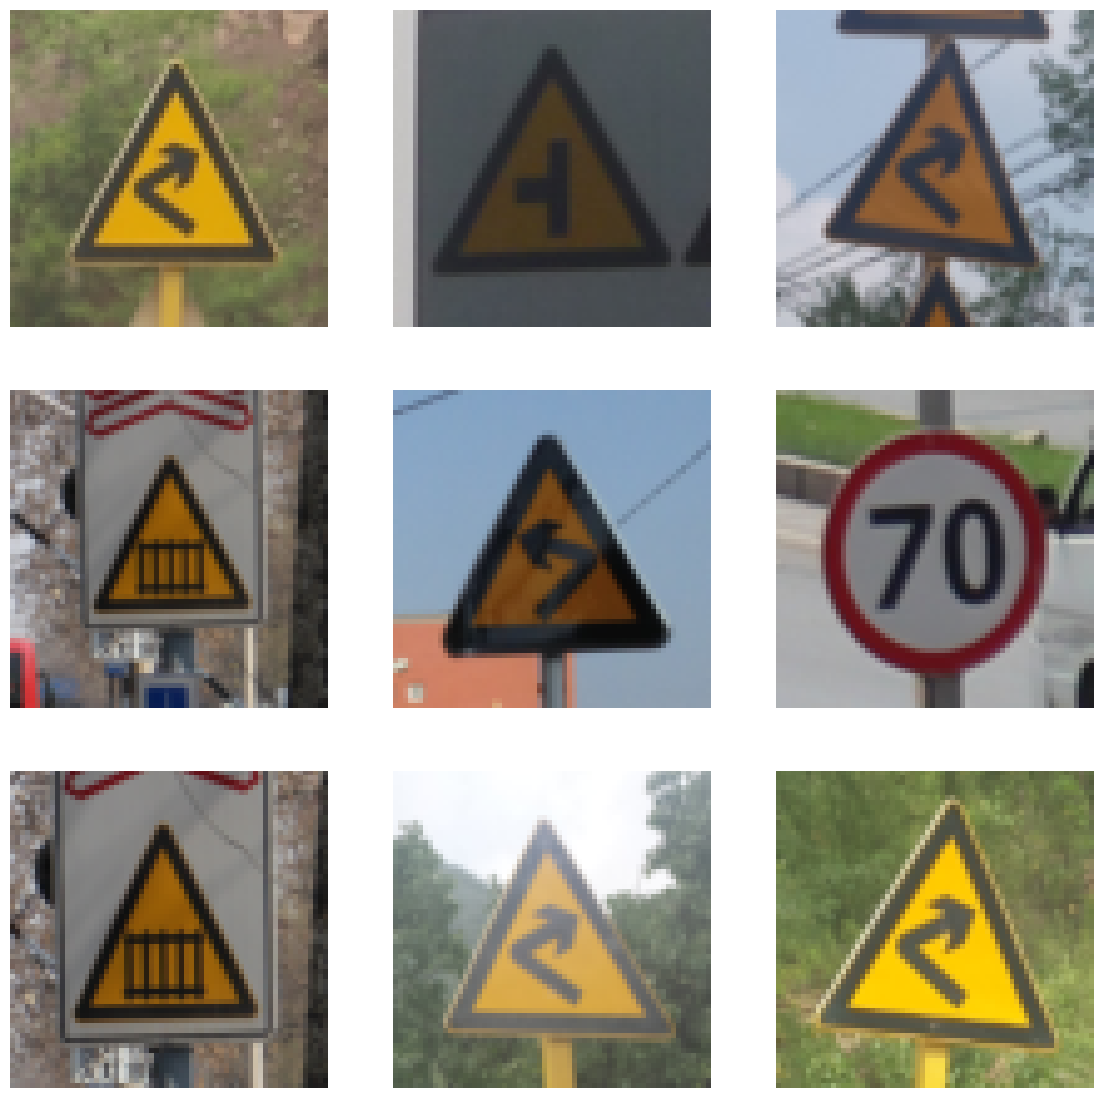

In [2]:
image_dir = '../data-students/TRAIN'
image_size = 64
batch_size = 16

transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
dataset = datasets.ImageFolder(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
classes = dataset.classes
print(classes)
# plot some images
fig, axes = plt.subplots(3, 3, figsize=(14, 14))
sample, _ = next(iter(dataloader))
sample = sample[:25]
idx = 0
for row in range(3):
    for col in range(3):
        axes[row, col].imshow(sample[idx].permute(1, 2, 0))
        axes[row, col].axis('off')
        idx += 1
plt.show()

In [3]:
def filter_dataloader_by_class(dataloader, target_idx):
    filtered_images = []
    for images, labels in dataloader:
        mask = labels == target_idx
        filtered_images.append(images[mask])
    filtered_images = torch.cat(filtered_images)
    filtered_labels = torch.full((len(filtered_images),), target_idx, dtype=torch.long)
    return DataLoader(TensorDataset(filtered_images, filtered_labels), batch_size=batch_size, shuffle=True)

# VAE MODE


In [5]:
# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1) 
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2*2*1024, 1024)
        self.mu = nn.Linear(1024, latent_dim)
        self.log_var = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = nn.LeakyReLU(0.02)(self.conv1(x))
        x = nn.BatchNorm2d(32)(x)
        x = nn.LeakyReLU(0.02)(self.conv2(x))
        x = nn.BatchNorm2d(64)(x)
        x = nn.LeakyReLU(0.02)(self.conv3(x))
        x = nn.BatchNorm2d(128)(x)
        x = nn.LeakyReLU(0.02)(self.conv4(x))
        x = nn.BatchNorm2d(256)(x)
        x = nn.LeakyReLU(0.02)(self.conv5(x))
        x = nn.BatchNorm2d(512)(x)
        x = nn.LeakyReLU(0.02)(self.conv6(x))
        x = nn.BatchNorm2d(1024)(x)
        x = self.flatten(x)
        x = nn.SELU()(self.fc(x))
        x = nn.BatchNorm1d(1024)(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 2*2*1024)
        self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv6 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        x = nn.SELU()(self.fc(z))
        x = x.view(-1, 1024, 2, 2)
        x = nn.LeakyReLU(0.02)(self.deconv1(x))
        x = nn.BatchNorm2d(512)(x)
        x = nn.LeakyReLU(0.02)(self.deconv2(x))
        x = nn.BatchNorm2d(256)(x)
        x = nn.LeakyReLU(0.02)(self.deconv3(x))
        x = nn.BatchNorm2d(128)(x)
        x = nn.LeakyReLU(0.02)(self.deconv4(x))
        x = nn.BatchNorm2d(64)(x)
        x = nn.LeakyReLU(0.02)(self.deconv5(x))
        x = nn.BatchNorm2d(32)(x)
        x = torch.sigmoid(self.deconv6(x))
        return x

# Define the VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

latent_dim = 512
vae = VAE(latent_dim)
print(vae)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=4096, out_features=1024, bias=True)
    (mu): Linear(in_features=1024, out_features=512, bias=True)
    (log_var): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=4096, bias=True)
    (deconv1): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(512, 256,

# TRAINING PER CLASS

In [ ]:
save_dir = 'vae_models'
os.makedirs(save_dir, exist_ok=True)
output_dir = 'output_images'
os.makedirs(output_dir, exist_ok=True)

#latent_dim = 256
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10000
num_classes = 10
print('starting training')

os.makedirs(save_dir, exist_ok=True)
for class_idx in range(num_classes):
    model = VAE(latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    filtered_dataloader = filter_dataloader_by_class(dataloader, class_idx)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, labels) in enumerate(filtered_dataloader):
            #data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, data, mu, log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        average_loss = train_loss / len(filtered_dataloader.dataset)
        if epoch % 50 == 0:
            print(f"Class {class_idx} Epoch {epoch}/{num_epochs}, Loss: {average_loss:.4f}")

    # Save the model
    model_path = os.path.join(save_dir, f"model_VAE_{classes[class_idx]}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for class {class_idx} saved to {model_path}")
    model = []

# Generate

In [6]:
save_dir = 'vae_models'
os.makedirs(save_dir, exist_ok=True)
output_dir = 'output_images'
os.makedirs(output_dir, exist_ok=True)

def load_vae_model(class_idx, latent_dim, device,save_dir=save_dir):
    model = VAE(latent_dim)
    model_path = os.path.join(save_dir, f"model_VAE_{classes[class_idx]}.pth")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

num_samples = 50

def plot_generated_images_from_vae(vae_model, class_idx, num_samples=num_samples, output_dir=output_dir, latent_dim = latent_dim):
    real_class_names = [12, 13, 24, 38, 39, 44, 46, 49, 50, 6]
    os.makedirs(output_dir, exist_ok=True)
    output_class_dir = os.path.join(output_dir, f"{classes[class_idx]}")
    os.makedirs(output_class_dir, exist_ok=True)

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = vae_model.decoder(z)

    for i in range(num_samples):
        sample = samples[i]
        sample_image = sample.permute(1, 2, 0).numpy()
        image_path = os.path.join(output_class_dir, f'{real_class_names[class_idx]}_{i}.png')
        plt.imsave(image_path, sample_image)

for class_idx in range(10):
  vae_model = load_vae_model(class_idx, latent_dim, device)
  plot_generated_images_from_vae(vae_model, class_idx, num_samples, output_dir,latent_dim)
  print(f"Generated images for class {classes[class_idx]} saved to {output_dir}/{classes[class_idx]}")

Generated images for class 12 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/12
Generated images for class 13 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/13
Generated images for class 24 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/24
Generated images for class 38 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/38
Generated images for class 39 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/39
Generated images for class 44 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/44
Generated images for class 46 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/46
Generated images for class 49 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/49
Generated images for class 50 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/50
Generated images for class 6 saved to C:/Users/Nicoli Leal/Desktop/project2/output_images/6


# SHOW RESULTS

In [31]:
real_images_dir = '../data-students/TRAIN'
generated_images_dir = 'output_images'
os.makedirs(generated_images_dir, exist_ok=True)

real_dataset = datasets.ImageFolder(real_images_dir, transform=transform)
generated_dataset = datasets.ImageFolder(generated_images_dir, transform=transform)

real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)
generated_dataloader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False)

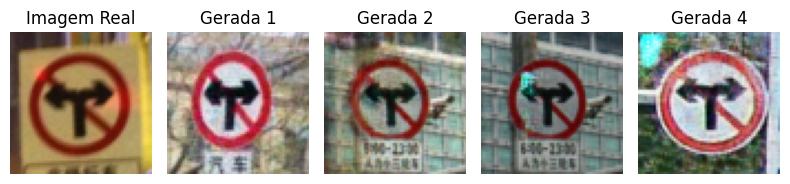

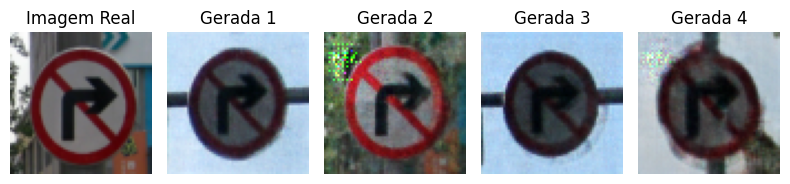

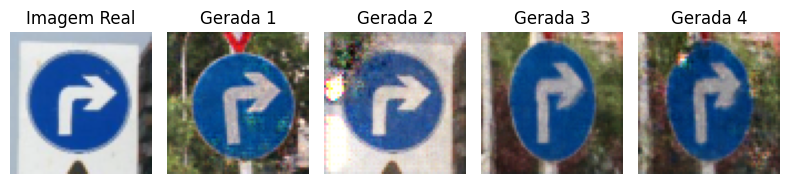

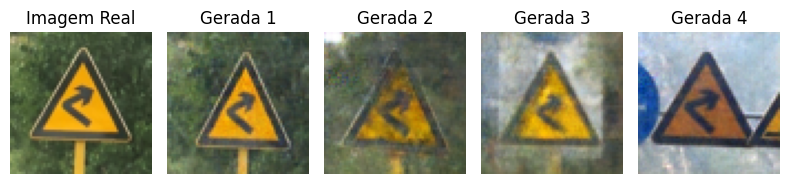

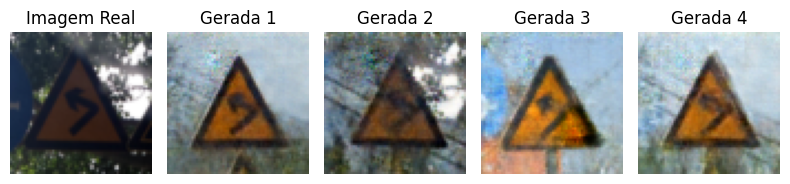

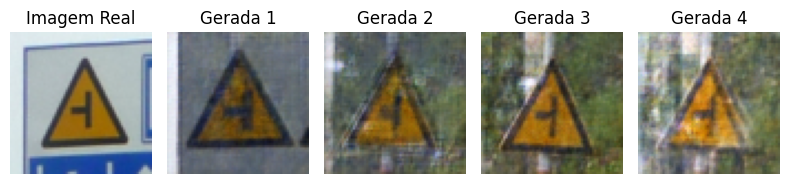

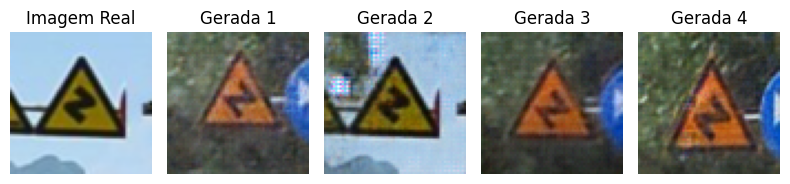

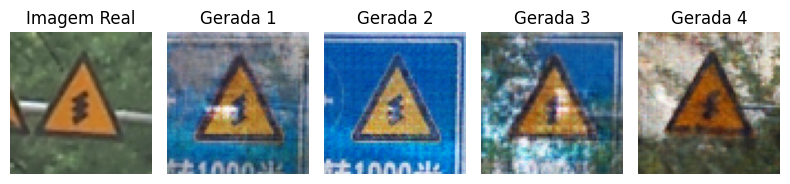

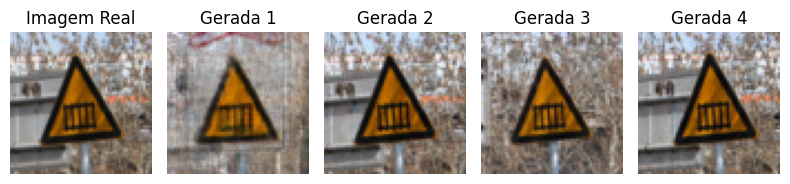

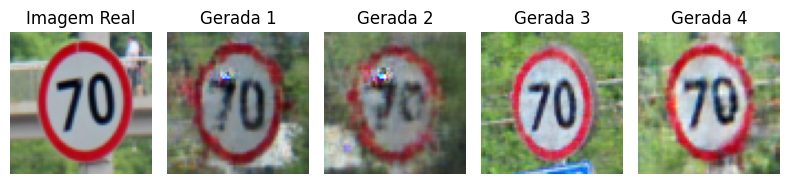

In [32]:
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)
generated_dataloader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False)

def plot_real_and_generated_images_by_class(real_dataloader, generated_dataloader, device, num_classes=10):
    
    for i in range(num_classes):
        filtered_dataloader_gen = filter_dataloader_by_class(generated_dataloader, i)
        filtered_dataloader_real = filter_dataloader_by_class(real_dataloader, i)
        real_batch = next(iter(filtered_dataloader_real))
        generated_batch = next(iter(filtered_dataloader_gen))
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 5, 1)
        plt.axis("off")
        plt.title("Real image")
        real_image = real_batch[0][0].to(device)
        plt.imshow(np.transpose(vutils.make_grid(real_image, padding=2, normalize=True).cpu(), (1, 2, 0)))

        for j in range(4):
            plt.subplot(1, 5, j + 2)
            plt.axis("off")
            plt.title(f"Generated image {j+1}")
            generated_image = generated_batch[0][j].to(device)  # Pega a j-ésima imagem gerada do lote
            plt.imshow(np.transpose(vutils.make_grid(generated_image, padding=2, normalize=True).cpu(), (1, 2, 0)))

        # Mostrar o plot
        plt.tight_layout()
        plt.show()

plot_real_and_generated_images_by_class(real_dataloader, generated_dataloader, device)